In [195]:
!pip install ucimlrepo

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# fetch dataset 
credit_approval = fetch_ucirepo(id=27) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 

#создаем датафрейм в удобном для нас формате pandas
df = pd.DataFrame(data=credit_approval.data.features, columns=credit_approval.variables.name)
#столбец A16 - таргет ("выдан займ или нет"), его нам дали в виде столбца со строками '+' и "-", поэтому для дальнейщего упрощения сразу заменим эти значения на 1 и 0 соответственно
df['A16']= y
df['A16'] = df["A16"].replace({"+": 1, "-": 0})

#выведем пять первых строк нашего датафрейма, чтобы примерно понимать, как выглядят наши данные

df.head()


name,A16,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1
0,1,0,202.0,g,f,1,t,t,1.25,v,w,g,u,0.000,30.83,b
1,1,560,43.0,g,f,6,t,t,3.04,h,q,g,u,4.460,58.67,a
2,1,824,280.0,g,f,0,f,t,1.50,h,q,g,u,0.500,24.50,a
3,1,3,100.0,g,t,5,t,t,3.75,v,w,g,u,1.540,27.83,b
4,1,0,120.0,s,f,0,f,t,1.71,v,w,g,u,5.625,20.17,b


## EDA -  exploratory data analysis ##

In [197]:
# variable information 


# Заметим, что категориальные переменные по определению могут принимать только ограниченное и обычно фиксированное количество возможных значений. Это свойство понадобится нам 
# при заполнении пропусков
# Так же категориальные переменные в данном датафрейме принимают только буквенные значения
# для удобства разделим переменные на категориальные и непрерывные
# сразу же дропнем переменную A16, так как она таргетная (поэтому срез с 1-ой строки)
continuous = credit_approval.variables[1:][credit_approval.variables[1:]['type']=='Continuous']
categorical = credit_approval.variables[1:][credit_approval.variables[1:]['type']=='Categorical']

In [198]:
continuous

,name,role,type,demographic,description,units,missing_values
1,A15,Feature,Continuous,None,None,None,no
2,A14,Feature,Continuous,None,None,None,yes
5,A11,Feature,Continuous,None,None,None,no
8,A8,Feature,Continuous,None,None,None,no
13,A3,Feature,Continuous,None,None,None,no
14,A2,Feature,Continuous,None,None,None,yes


In [199]:
categorical


,name,role,type,demographic,description,units,missing_values
3,A13,Feature,Categorical,None,None,None,no
4,A12,Feature,Categorical,None,None,None,no
6,A10,Feature,Categorical,None,None,None,no
7,A9,Feature,Categorical,None,None,None,no
9,A7,Feature,Categorical,None,None,None,yes
10,A6,Feature,Categorical,None,None,None,yes
11,A5,Feature,Categorical,None,None,None,yes
12,A4,Feature,Categorical,None,None,None,yes
15,A1,Feature,Categorical,None,None,None,yes


In [200]:
# Заполним пропуски, а так же проиллюстрируем их заполнение:
# для начала в таблицу started_blanks запишем количество пропусков в каждом столбце
started_blanks = df.isna().sum()
# непосредственно заполним пропуска
for name in credit_approval.variables.name[1:]:
    if (df[name].isna().sum()!=0):
        if ((df[name].dtype == int) or (df[name].dtype == float)): # если в столбце не строки, а числа, то заполним средним значением (если переменные непрерывные)
            
            fill_value = df[name].mean()
            df[name].fillna(fill_value, inplace=True)
        else:
           
            # если переменная категориальная, то по свойству, описанному выше, кажется логичным заполнить пропуски самым популярным значением в столбце
            counted_values = df[name].value_counts()
            most_common =counted_values.idxmax()
            df[name].fillna(most_common, inplace=True)
# создадим еще одну таблицу с количеством пропусков, но уже в заполненном датафрейме
finished_blanks = df.isna().sum()

print("До заполнения")
print(started_blanks)
print("")
print("После заполнения")
print(finished_blanks)

До заполнения
name
A16     0
A15     0
A14    13
A13     0
A12     0
A11     0
A10     0
A9      0
A8      0
A7      9
A6      9
A5      6
A4      6
A3      0
A2     12
A1     12
dtype: int64

После заполнения
name
A16    0
A15    0
A14    0
A13    0
A12    0
A11    0
A10    0
A9     0
A8     0
A7     0
A6     0
A5     0
A4     0
A3     0
A2     0
A1     0
dtype: int64


Теперь изучим распределение переменных в столбцах, где каждый элемент - числовое значение. Иными словами, рассмотрим распределение непрерывных переменных:

Для начала выведем основную информацию о столбцах с непрерывными переменными

In [201]:
df.describe()
# count - The number of not-empty values.
# mean - The average (mean) value.
# std - The standard deviation.
# min - the minimum value.
# 25% - The 25% percentile*.
# 50% - The 50% percentile*.
# 75% - The 75% percentile*.
# max - the maximum value.

name,A16,A15,A14,A11,A8,A3,A2
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000
mean,0.444928,1017.385507,184.014771,2.40000,2.223406,4.758725,31.568171
std,0.497318,5210.102598,172.159274,4.86294,3.346513,4.978163,11.853273
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,13.750000
25%,0.000000,0.000000,80.000000,0.00000,0.165000,1.000000,22.670000
50%,0.000000,5.000000,160.000000,0.00000,1.000000,2.750000,28.625000
75%,1.000000,395.500000,272.000000,3.00000,2.625000,7.207500,37.707500
max,1.000000,100000.000000,2000.000000,67.00000,28.500000,28.000000,80.250000


In [202]:

updatemenu = [dict()]
buttons = []
fig = go.Figure()
data =[]
for i in continuous.name:
    trace = px.histogram(df[i]).data[0]
    trace.visible = False
    data.append(trace) 
fig.add_traces(data) 

for i, col in enumerate(continuous.name):

    visibles = [False] * len(continuous.name)
    visibles[i] = True
    buttons.append(dict(method='restyle',
                        label=col,
                        args=["visible", visibles]
                        ))

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig.update_layout(showlegend=True, updatemenus=updatemenu)
fig.update_layout(
     title={
        "text": "Распределение непрерывных переменных",
        "x": 0.5
    },
    xaxis_title="Диапазон",
    yaxis_title="Количество значений"
)
fig.show()

Теперь рассмотрим распределение категориальных переменных

In [203]:
updatemenu = [dict()]
buttons = []
fig2 = go.Figure()

data =[]
for i in categorical.name[1:]:
    trace = px.histogram(df[i]).data[0]
    trace.visible = False
    data.append(trace) 
fig2.add_traces(data) 

for i, col in enumerate(categorical.name):

    visibles = [False] * len(categorical.name)
    visibles[i] = True
    buttons.append(dict(method='restyle',
                        label=col,
                        args=["visible", visibles]
                        ))

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig2.update_layout(showlegend=True, updatemenus=updatemenu)
fig2.update_layout(
     title={
        "text": "Распределение категориальных переменных",
        "x": 0.5
    },
    xaxis_title="Значение",
    yaxis_title="Количество значений"
)
fig2.show()



Также необходимо посмотреть на корреляцию непрерывных переменных

In [204]:
df.corr()

name,A16,A15,A14,A11,A8,A3,A2
name,,,,,,,
A16,1.000000,0.175657,-0.099972,0.406410,0.322475,0.206294,0.161627
A15,0.175657,1.000000,0.065609,0.063692,0.051345,0.123121,0.018539
A14,-0.099972,0.065609,1.000000,-0.119809,-0.076389,-0.222346,-0.077161
A11,0.406410,0.063692,-0.119809,1.000000,0.322330,0.271207,0.185575
A8,0.322475,0.051345,-0.076389,0.322330,1.000000,0.298902,0.392787
A3,0.206294,0.123121,-0.222346,0.271207,0.298902,1.000000,0.201316
A2,0.161627,0.018539,-0.077161,0.185575,0.392787,0.201316,1.000000


In [205]:
fig_cor = px.imshow(df.corr(), text_auto=True)
fig_cor.update_layout(
     title={
        "text": "Корреляция непрерывных переменных",
        "x": 0.5
    },

)
fig_cor.show()

Отсюда можем видеть, что A15 слабо коррелирует со всеми прочими признаками, а значит позже имеет смысл рассмотреть его подробнее.

Теперь поработаем с категориальными признаками. 

Очевидно, работать с некоторым дискретным набором строковых значений неудобно для анализа, поиска зависимостей и построения гипотез. В этом случае нас выручит метод преобразования категориальных столбцов в столбцы, где каждому из принимаемых признаком значений соответсвует единственная цифра.

Например, если у нас были признаки A1, A2, что содержали наборы значений из словаря {"a", "b", "c"}:

$$\begin{array}{cc}
A1 & A2 \\
a & b \\
c & a \\
b & c \\
a & b \\
\end{array}$$

то в измененном датафрейме при создании фиктивных переменных мы получим признаки $A1$, $A2$

$$\begin{array}{cc}
A1 & A2 \\
1 & 2 \\
3 & 1 \\
2 & 3 \\
1 & 2 \\
\end{array}$$

Возьмём признаки из списка "categorical":

In [206]:
categorical.name

3     A13
4     A12
6     A10
7      A9
9      A7
10     A6
11     A5
12     A4
15     A1
Name: name, dtype: object

In [207]:
!pip install category_encoders

In [208]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=categorical.name)
df = encoder.fit_transform(df)
#уберем из дата фрейма нашу таргетную переменную - A16
target = df['A16']
df = df.drop(["A16"], axis = 1)
#таргетную переменную тоже преобразуем в числа (0 и 1), так как нам этот столбец дан в формате строк


Проведём небольшой EDA с фиктивными переменными. Для начала, исследуем корреляцию:

In [209]:

fig_cor = px.imshow(df.corr(), text_auto=True)
fig_cor.update_layout(
     title={
        "text": "Корреляция вместе c фиктивными переменных, представляющих категориальные",
        "x": 0.5
    },

)
fig_cor.show()


In [210]:
df.describe()

name,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1
count,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,1017.385507,184.014771,1.105797,1.457971,2.40000,1.572464,1.476812,2.223406,1.847826,6.960870,1.242029,1.242029,4.758725,31.568171,1.304348
std,5210.102598,172.159274,0.343458,0.498592,4.86294,0.495080,0.499824,3.346513,1.395110,3.802822,0.435342,0.435342,4.978163,11.853273,0.460464
min,0.000000,0.000000,1.000000,1.000000,0.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,13.750000,1.000000
25%,0.000000,80.000000,1.000000,1.000000,0.00000,1.000000,1.000000,0.165000,1.000000,3.000000,1.000000,1.000000,1.000000,22.670000,1.000000
50%,5.000000,160.000000,1.000000,1.000000,0.00000,2.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,2.750000,28.625000,1.000000
75%,395.500000,272.000000,1.000000,2.000000,3.00000,2.000000,2.000000,2.625000,2.000000,10.000000,1.000000,1.000000,7.207500,37.707500,2.000000
max,100000.000000,2000.000000,3.000000,2.000000,67.00000,2.000000,2.000000,28.500000,9.000000,14.000000,3.000000,3.000000,28.000000,80.250000,2.000000


Разделим нашу выборку на тестовую и валидационную

In [211]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)


## Постановка задачи ##


Наш датасэт представляет собой данные об одобрении заявление на получение кредитных карт. Иными словами, на вход поступает вектор признаков и на их основе банк выдает категориальный ответ: "одобрено" или "неодобрено".
Для банка важно с точностью определять добросоветсных и не добросовестных заемщиков, чтобы не допустить как большой доли упущенной выгоды (в случае, если откажут хорошему заемщику), так и больших потерь (слишком много одобренных кредитов, которые потом не возвращаются).
Наша цель : по вектору признаков достаточно точно определять можно ли выдать человеку займ, то есть классифицировать "хороших" и "плохих" заемщиков.

## Методы оценивания ##
to be continued



## Тестирование разных моделей машинного обучения ##

Начнём пробовать различные модели машинного обучения. Рассмотрим самую простенькую модель линейной регрессии:

In [212]:
# создание модели линейной регрессии
model = LinearRegression()

# обучение модели
model.fit(X_train, y_train)

# получение прогнозов
y_pred = model.predict(X_test)

# оценка качества модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f"Среднеквадратичная ошибка (MSE): {mse}")
print(f"Коэффициент детерминации (R^2): {r2}")

print("\n")

# Получение коэффициентов регрессии
coefficients = pd.DataFrame({'Признак': X_train.columns.ravel(), 'Коэффициент': model.coef_.ravel()})
print(coefficients)

Среднеквадратичная ошибка (MSE): 0.13458523569804262
Коэффициент детерминации (R^2): 0.4615459603711085


   Признак  Коэффициент
0      A15     0.000014
1      A14    -0.000063
2      A13     0.066686
3      A12    -0.028628
4      A11     0.007701
5      A10    -0.117320
6       A9    -0.610784
7       A8     0.007935
8       A7    -0.005002
9       A6    -0.007314
10      A5    -0.031922
11      A4    -0.031922
12      A3    -0.002642
13      A2     0.001461
14      A1     0.025642


/var/folders/q2/14m9wqwd7blcr7txyywgdkkm0000gn/T/ipykernel_56989/378686754.py:21: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



Проиллюстрируем работу модели линейно регрессии:

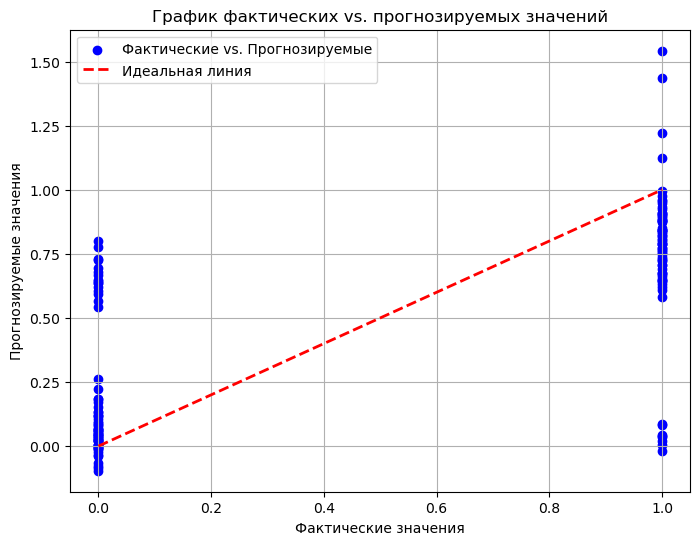

In [213]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Фактические vs. Прогнозируемые')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Идеальная линия')
plt.xlabel('Фактические значения')
plt.ylabel('Прогнозируемые значения')
plt.title('График фактических vs. прогнозируемых значений')
plt.legend()
plt.grid(True)

plt.show()

Теперь возьмём модель логистической регрессии:

In [214]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# создание модели логистической регрессии
model = LogisticRegression()

# обучение модели
model.fit(X_train, y_train)

# получение прогнозов
y_pred = model.predict(X_test)

# оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# печать точности, матрица ошибок и отчёта о классификации
print(f"Точность модели: {accuracy:.2f}")
print("Матрица ошибок (Confusion Matrix):")
print(confusion)
print("Отчет о классификации:")
print(classification_report_str)

Точность модели: 0.73
Матрица ошибок (Confusion Matrix):
[[57 11]
 [26 44]]
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.69      0.84      0.75        68
           1       0.80      0.63      0.70        70

    accuracy                           0.73       138
   macro avg       0.74      0.73      0.73       138
weighted avg       0.74      0.73      0.73       138



/Users/amirzoyeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## Модель классификации ##

Так как наша таргетная переменная представляет собой категориальный признак: одобрен или не одобрен кредит, то задачу предсказывания таких ответов можно отнести к задаче классификации в машинном обучении.

Классификацию можно производить с помощью множества алгоритмов, но мы рассмотрим один из самых простых - метод случайного леса.

Этот алгоритм основывается на том, что случайным образом строятся несколько деревьев решений, каждое из которых определяет значение класса таргетной категориальной переменной  (например, 0 или 1). После этого определяется предсказание: в условиях задачи классификации класс с наибольшим числом голосов от случайных деревье становится прогнозом алгоритма. Случайность в построении деревьев достигается таким образом: случайным образом выбираются с повторениями примеры из исходных данных, чтобы создать подвыборки для каждого дерева, далее эти подвыборки делятся на узлы дерева по одному на каждый и так строится дерево решений различной глубины. По умолчанию в функции из библиотеки sklearn количество деревьев в лесу - 10.

In [215]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, classification_report

rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Model accuracy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


Model accuracy: 0.8623


Выведу основные метрики точности модели и проиллюстрирую ее работу на матрице ошибок:


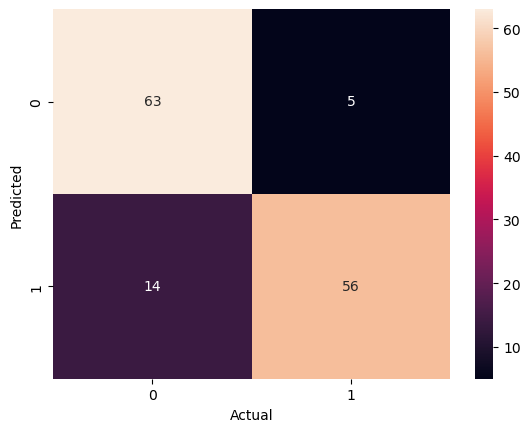

In [216]:
cm = confusion_matrix(y_test, y_pred)

fig_mis = px.imshow(cm, text_auto=True)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [217]:
print('accuracy_score= {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('recall_score = {:.3f}'.format(recall_score(y_test, y_pred)))
print('precision_score = {:.3f}'.format(precision_score(y_test, y_pred)))

accuracy_score= 0.862
recall_score = 0.800
precision_score = 0.918


Так же библиотека позволяет нам вывести "важность" каждого признака в предсказаниях деревьев:

In [218]:
features_importance = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
features_importance

name
A9     0.303131
A8     0.106889
A11    0.092417
A15    0.082871
A2     0.075874
A3     0.072177
A14    0.069325
A10    0.055627
A6     0.049274
A7     0.027653
A13    0.016236
A12    0.014481
A5     0.013110
A1     0.011151
A4     0.009785
dtype: float64

In [219]:
fig = px.bar(x=features_importance.index, y=features_importance)
fig.update_layout(
     title={
        "text": "Важность признаков",
        "x": 0.5
    },
    xaxis_title="Признак",
    yaxis_title="Показатель важности"
)
fig.update_xaxes(categoryorder='total ascending')  
fig.show()
